# Clasificación de textos cortos en emociones

## Contexto:
El análisis de sentimientos es un área que genera valor en múltiples industrias. Usualmente se utilizan técnicas de NLP para clasificar rápidamente textos en un sentimiento positivo, negativo o neutral. Sin embargo, esta clasificación es bastante limitada y no permite un entendimiento profundo. Por esto, se requiere clasificar textos cortos en un espectro de emociones.

Para este caso se abordan las emociones desde un punto de vista clásico en el cual se clasifican en 7 emociones principales: 
1) `shame` = vergüenza
2) `sadness` = tristeza
3) `joy` = alegría
4) `guilt` = culpa
5) `fear` = miedo
6) `disgust` = asco
7) `anger` = ira

Se utiliza el conjunto de datos **ISEAR**, que consiste de 7666 encuestas realizadas por múltiples psicológos en los años 90 en varios países. La encuesta consistía en presentarle una emoción al entrevistado y este debía responder una situación que representara dicha emoción. Este dataset fue elegido porque ha sido ampliamente utilizado para entrenar y comparar el rendimiento de modelos en la detección de emociones.

## Objetivo:
El objetivo de este Notebook es evaluar el rendimiento de diferentes modelos para la clasificación del texto en emociones.

## Procedimiento:
Se van a evaluar el rendimiento de modelos correspondientes a diferentes técnicas: técnicas de **machine learning**, técnicas de **redes neuronales** y **transformers**

## 0. Libraries and input data

In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier

import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors


In [2]:
df = pd.read_parquet("../data/cleaned/isear_cleaned.parquet")
df.head(3)

,text,emotion
0,when a boy tried to fool me so he would be ok ...,anger
1,i felt anger when i saw that i was being misle...,anger
2,once a friend had pushed me and i had fallen o...,anger


## 1. Técnicas de Machine Learning

Se van a utilizar los modelos de `support vector machine`, `decision tree classifier` y `random forests classifier` para realizar un proceso de clasificación multiclase.

### Libraries

### Split dataset into train, test and validation

In [7]:
# Supongamos que df_cleaned contiene las columnas 'text' y 'emotion'
X = df["text"]
y = df["emotion"]

# Dividimos los datos en entrenamiento (60%), validación (20%) y prueba (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


#### Support Vector Classifier (SVC)

Starting Grid Search...


  0%|          | 0/64 [00:00<?, ?it/s]/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
320 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Best Model Parameters from Validation: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'vectorizer': TfidfVectorizer(max_features=5000)}

Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.46      0.58      0.51       108
     disgust       0.61      0.58      0.60       107
        fear       0.72      0.73      0.73       108
       guilt       0.51      0.49      0.50       107
         joy       0.73      0.70      0.71       109
     sadness       0.58      0.50      0.54       108
       shame       0.48      0.48      0.48       106

    accuracy                           0.58       753
   macro avg       0.59      0.58      0.58       753
weighted avg       0.59      0.58      0.58       753

Combining Training and Validation sets...
Retraining the best model with combined Training and Validation sets...


100%|██████████| 1/1 [00:09<00:00,  9.90s/it]


Evaluating on Test set...


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



Test Classification Report:
              precision    recall  f1-score   support

       anger       0.44      0.49      0.46       109
     disgust       0.55      0.64      0.59       107
        fear       0.80      0.72      0.75       109
       guilt       0.49      0.47      0.48       106
         joy       0.79      0.74      0.77       109
     sadness       0.60      0.56      0.58       108
       shame       0.45      0.44      0.45       106

    accuracy                           0.58       754
   macro avg       0.59      0.58      0.58       754
weighted avg       0.59      0.58      0.58       754



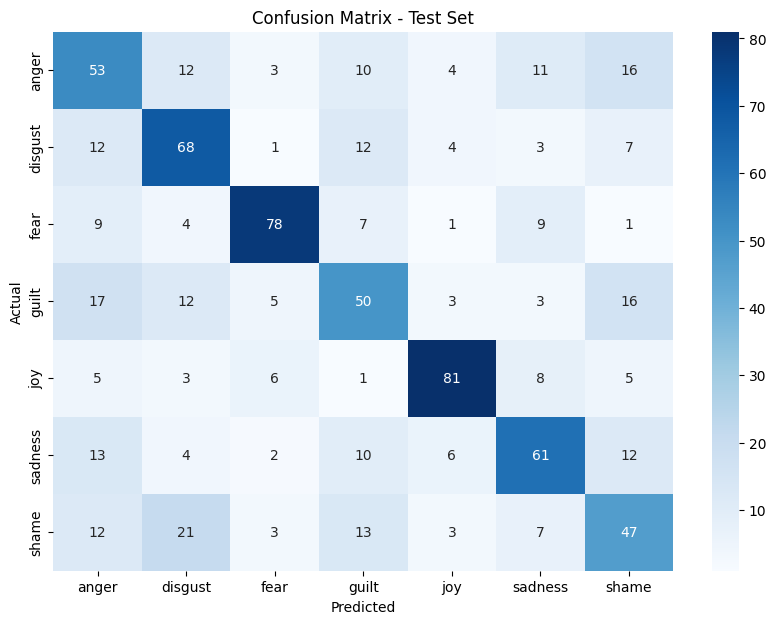

Test Metrics DataFrame:


,Model,Test Macro Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,SVM,0.580902,0.587406,0.580054,0.582579,"{'classifier__C': 10, 'classifier__class_weigh..."


In [10]:
# Step 1: Track grid search progress and training

# Create vectorizers for Word2Vec and GloVe (already covered)
word2vec_model = Word2Vec(
    sentences=[text.split() for text in X_train],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
)
glove_model = api.load("glove-wiki-gigaword-100")  # Pre-trained GloVe model

# Word2Vec and GloVe transformers
word2vec_transformer = Word2VecVectorizer(word2vec_model)
glove_transformer = Word2VecVectorizer(glove_model)

# Additional vectorizers
vectorizers = {
    "tfidf": TfidfVectorizer(max_features=5000),
    "count": CountVectorizer(max_features=5000),
    "word2vec": word2vec_transformer,
    "glove": glove_transformer,
}

# Define the pipeline with SVC
pipeline = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),  # Placeholder
        ("classifier", SVC()),
    ]
)

# Define the parameter grid
param_grid = [
    {
        "vectorizer": [
            vectorizers["tfidf"],
            vectorizers["count"],
            vectorizers["word2vec"],
            vectorizers["glove"],
        ],
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__kernel": ["linear", "rbf", "poly", "sigmoid"],
        "classifier__gamma": ["scale", "auto"],
        "classifier__class_weight": [None, "balanced"],
    }
]

# Grid search for SVC
print("Starting Grid Search...")
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=0
)
grid_search.fit(X_train, y_train)

# Validation evaluation
y_val_pred = grid_search.best_estimator_.predict(X_val)
val_report = classification_report(y_val, y_val_pred, output_dict=True)

print(f"\nBest Model Parameters from Validation: {grid_search.best_params_}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Step 2: Combine train and validation datasets, and retrain the best model
print("Combining Training and Validation sets...")
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = np.hstack([y_train, y_val])

# Retrain the best model
print("Retraining the best model with combined Training and Validation sets...")
best_model = grid_search.best_estimator_
best_model.fit(X_train_val, y_train_val)

# Step 3: Test evaluation
print("Evaluating on Test set...")
y_test_pred = best_model.predict(X_test)

# Print test classification report
test_report = classification_report(y_test, y_test_pred, output_dict=True)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred, labels=grid_search.classes_)
cm_test_df = pd.DataFrame(
    cm_test, index=grid_search.classes_, columns=grid_search.classes_
)

# Plot confusion matrix for the test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 4: Extract and display test metrics
test_metrics_data = {
    "Model": ["SVM"],
    "Test Macro Accuracy": [test_report["accuracy"]],
    "Test Macro Precision": [test_report["macro avg"]["precision"]],
    "Test Macro Recall": [test_report["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report["macro avg"]["f1-score"]],
    "Best Parameters": [grid_search.best_params_],
}

# Create DataFrame to store test metrics
test_metrics_df = pd.DataFrame(test_metrics_data)

# Display test metrics DataFrame
print("Test Metrics DataFrame:")
display(test_metrics_df)


#### Decision Tree Clasifier

Starting Grid Search for Decision Tree...


  0%|          | 0/96 [00:00<?, ?it/s]/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Best Decision Tree Parameters from Validation: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'vectorizer': CountVectorizer(max_features=5000)}

Decision Tree Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.48      0.37      0.42       108
     disgust       0.52      0.43      0.47       107
        fear       0.57      0.53      0.55       108
       guilt       0.43      0.47      0.45       107
         joy       0.55      0.60      0.57       109
     sadness       0.42      0.44      0.43       108
       shame       0.34      0.43      0.38       106

    accuracy                           0.47       753
   macro avg       0.47      0.47      0.47       753
weighted avg       0.47      0.47      0.47       753

Retraining the best Decision Tree model with combined Training and Validation se

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Evaluating Decision Tree on Test set...


100%|██████████| 1/1 [00:00<00:00, 61.46it/s]



Decision Tree Test Classification Report:
              precision    recall  f1-score   support

       anger       0.36      0.34      0.35       109
     disgust       0.50      0.50      0.50       107
        fear       0.60      0.51      0.55       109
       guilt       0.41      0.36      0.38       106
         joy       0.56      0.54      0.55       109
     sadness       0.50      0.53      0.51       108
       shame       0.32      0.41      0.36       106

    accuracy                           0.46       754
   macro avg       0.46      0.46      0.46       754
weighted avg       0.46      0.46      0.46       754



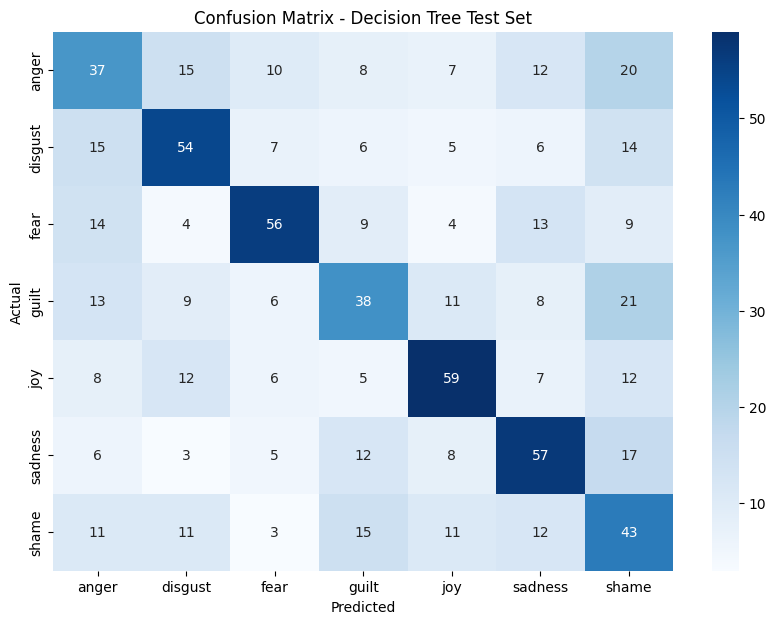

Updated Test Metrics DataFrame with Decision Tree Results:


,Model,Test Macro Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,SVM,0.580902,0.587406,0.580054,0.582579,"{'classifier__C': 10, 'classifier__class_weigh..."
1,Decision Tree,0.456233,0.462894,0.455871,0.457728,"{'classifier__class_weight': 'balanced', 'clas..."


In [11]:
from sklearn.tree import DecisionTreeClassifier

# Step 1: Define a pipeline for Decision Tree Classifier
pipeline_dt = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),  # Placeholder
        ("classifier", DecisionTreeClassifier()),
    ]
)

# Define the parameter grid for the Decision Tree
param_grid_dt = [
    {
        "vectorizer": [
            vectorizers["tfidf"],
            vectorizers["count"],
            vectorizers["word2vec"],
            vectorizers["glove"],
        ],
        "classifier__criterion": ["gini", "entropy"],  # Splitting criteria
        "classifier__max_depth": [None, 10, 20, 30],  # Maximum tree depth
        "classifier__min_samples_split": [2, 5, 10],  # Min samples to split a node
        "classifier__min_samples_leaf": [1, 2, 4],  # Min samples in a leaf node
        "classifier__class_weight": [None, "balanced"],  # Class weight handling
    }
]

# Step 2: Perform Grid Search for Decision Tree
print("Starting Grid Search for Decision Tree...")
grid_search_dt = GridSearchCV(
    pipeline_dt, param_grid_dt, cv=5, scoring="accuracy", n_jobs=-1, verbose=0
)
grid_search_dt.fit(X_train, y_train)

# Step 3: Validation evaluation for Decision Tree
y_val_pred_dt = grid_search_dt.best_estimator_.predict(X_val)
val_report_dt = classification_report(y_val, y_val_pred_dt, output_dict=True)

print(f"\nBest Decision Tree Parameters from Validation: {grid_search_dt.best_params_}")
print("\nDecision Tree Validation Classification Report:")
print(classification_report(y_val, y_val_pred_dt))

# Combine train and validation datasets
X_train_val_dt = pd.concat([X_train, X_val], axis=0)
y_train_val_dt = np.hstack([y_train, y_val])

# Step 4: Retrain the best Decision Tree model with the combined training and validation data
print(
    "Retraining the best Decision Tree model with combined Training and Validation sets..."
)
best_model_dt = grid_search_dt.best_estimator_
best_model_dt.fit(X_train_val_dt, y_train_val_dt)

# Step 5: Test evaluation for Decision Tree
print("Evaluating Decision Tree on Test set...")
y_test_pred_dt = best_model_dt.predict(X_test)

# Print Decision Tree test classification report
test_report_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)
print("\nDecision Tree Test Classification Report:")
print(classification_report(y_test, y_test_pred_dt))

# Confusion matrix for Decision Tree test set
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt, labels=grid_search_dt.classes_)
cm_test_df_dt = pd.DataFrame(
    cm_test_dt, index=grid_search_dt.classes_, columns=grid_search_dt.classes_
)

# Plot confusion matrix for Decision Tree test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_dt, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Decision Tree Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 6: Extract Decision Tree test metrics and append them to test_metrics_df
test_metrics_data_dt = {
    "Model": ["Decision Tree"],
    "Test Macro Accuracy": [test_report_dt["accuracy"]],
    "Test Macro Precision": [test_report_dt["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_dt["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_dt["macro avg"]["f1-score"]],
    "Best Parameters": [grid_search_dt.best_params_],
}

# Convert the Decision Tree metrics to DataFrame
test_metrics_df_dt = pd.DataFrame(test_metrics_data_dt)

# Append Decision Tree metrics to the existing test_metrics_df
test_metrics_df = pd.concat([test_metrics_df, test_metrics_df_dt], ignore_index=True)

# Display the updated metrics DataFrame
print("Updated Test Metrics DataFrame with Decision Tree Results:")
display(test_metrics_df)


#### Random Forests Classifier

Starting Grid Search for Random Forest...


  0%|          | 0/32 [00:00<?, ?it/s]/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  


Best Random Forest Parameters from Validation: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'vectorizer': CountVectorizer(max_features=5000)}

Random Forest Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.48      0.53      0.50       108
     disgust       0.61      0.58      0.60       107
        fear       0.66      0.69      0.68       108
       guilt       0.53      0.48      0.50       107
         joy       0.54      0.72      0.62       109
     sadness       0.60      0.48      0.53       108
       shame       0.55      0.47      0.51       106

    accuracy                           0.57       753
   macro avg       0.57      0.57      0.56       753
weighted avg       0.57      0.57      0.56       753

Retraining the best Random Forest model with combined Training and Validation sets...


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Evaluating Random Forest on Test set...


100%|██████████| 1/1 [00:00<00:00, 48.81it/s]



Random Forest Test Classification Report:
              precision    recall  f1-score   support

       anger       0.47      0.50      0.48       109
     disgust       0.54      0.64      0.59       107
        fear       0.72      0.72      0.72       109
       guilt       0.49      0.44      0.47       106
         joy       0.65      0.73      0.69       109
     sadness       0.68      0.59      0.63       108
       shame       0.49      0.42      0.46       106

    accuracy                           0.58       754
   macro avg       0.58      0.58      0.58       754
weighted avg       0.58      0.58      0.58       754



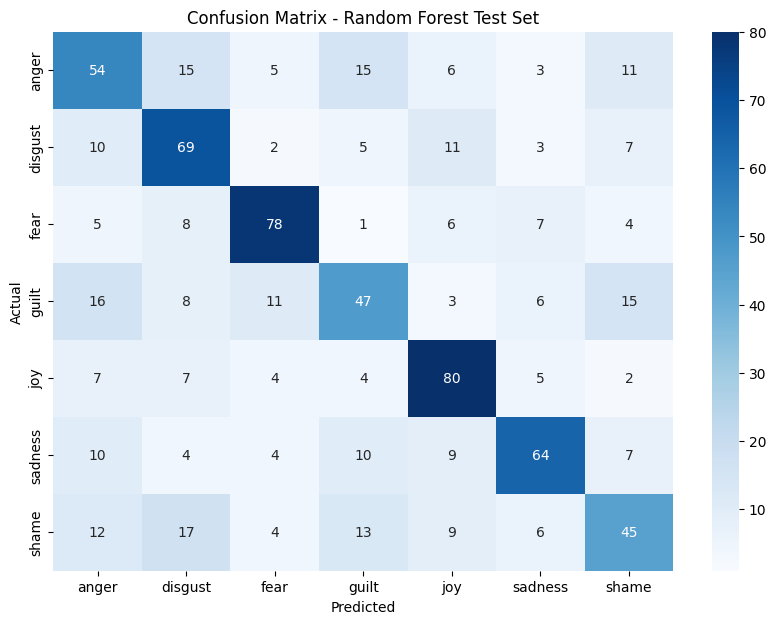

Updated Test Metrics DataFrame with Random Forest Results:


,Model,Test Macro Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,SVM,0.580902,0.587406,0.580054,0.582579,"{'classifier__C': 10, 'classifier__class_weigh..."
1,Decision Tree,0.456233,0.462894,0.455871,0.457728,"{'classifier__class_weight': 'balanced', 'clas..."
2,Random Forest,0.579576,0.578603,0.578619,0.576472,"{'classifier__criterion': 'gini', 'classifier_..."


In [14]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Define a pipeline for Random Forest Classifier
pipeline_rf = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),  # Placeholder
        ("classifier", RandomForestClassifier()),
    ]
)

# Define the parameter grid for the Random Forest
param_grid_rf = [
    {
        "vectorizer": [
            vectorizers["tfidf"],
            vectorizers["count"],
            vectorizers["word2vec"],
            vectorizers["glove"],
        ],
        "classifier__n_estimators": [10, 50, 100, 150, 200],  # Number of trees
        "classifier__criterion": ["gini", "entropy", "log_loss"],
        "classifier__max_depth": [None, 10, 20, 30],  # Maximum depth of trees
        "classifier__min_samples_split": [
            2,
            5,
            7,
            10,
        ],  # Minimum number of samples to split a node
        "classifier__min_samples_leaf": [
            1,
            2,
            4,
        ],  # Minimum number of samples at a leaf node
        "classifier__class_weight": [None, "balanced"],  # Class weight balancing
    }
]

# Grid search for Random Forest with progress tracking removed
print("Starting Grid Search for Random Forest...")
grid_search_rf = GridSearchCV(
    pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1, verbose=0
)
grid_search_rf.fit(X_train, y_train)

# Step 2: Validation evaluation for Random Forest
y_val_pred_rf = grid_search_rf.best_estimator_.predict(X_val)
val_report_rf = classification_report(y_val, y_val_pred_rf, output_dict=True)

print(f"\nBest Random Forest Parameters from Validation: {grid_search_rf.best_params_}")
print("\nRandom Forest Validation Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

# Combine train and validation datasets
X_train_val_rf = pd.concat([X_train, X_val], axis=0)
y_train_val_rf = np.hstack([y_train, y_val])

# Step 3: Retrain the best Random Forest model with the combined training and validation data
print(
    "Retraining the best Random Forest model with combined Training and Validation sets..."
)
best_model_rf = grid_search_rf.best_estimator_
best_model_rf.fit(X_train_val_rf, y_train_val_rf)

# Step 4: Test evaluation for Random Forest
print("Evaluating Random Forest on Test set...")
y_test_pred_rf = best_model_rf.predict(X_test)

# Print Random Forest test classification report
test_report_rf = classification_report(y_test, y_test_pred_rf, output_dict=True)
print("\nRandom Forest Test Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

# Confusion matrix for Random Forest test set
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf, labels=grid_search_rf.classes_)
cm_test_df_rf = pd.DataFrame(
    cm_test_rf, index=grid_search_rf.classes_, columns=grid_search_rf.classes_
)

# Plot confusion matrix for Random Forest test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test_df_rf, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Random Forest Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Step 5: Extract Random Forest test metrics and append them to test_metrics_df
test_metrics_data_rf = {
    "Model": ["Random Forest"],
    "Test Macro Accuracy": [test_report_rf["accuracy"]],
    "Test Macro Precision": [test_report_rf["macro avg"]["precision"]],
    "Test Macro Recall": [test_report_rf["macro avg"]["recall"]],
    "Test Macro F1-Score": [test_report_rf["macro avg"]["f1-score"]],
    "Best Parameters": [grid_search_rf.best_params_],
}

# Convert the Random Forest metrics to DataFrame
test_metrics_df_rf = pd.DataFrame(test_metrics_data_rf)

# Append Random Forest metrics to the existing test_metrics_df
test_metrics_df = pd.concat([test_metrics_df, test_metrics_df_rf], ignore_index=True)

# Display the updated metrics DataFrame
print("Updated Test Metrics DataFrame with Random Forest Results:")
display(test_metrics_df)


### Evaluation of Machine Learning Models

Based on the metrics against test set and using **Macro F1-Score** decision criteria, the best Machine Learning to clasificate Text in Emotions is **SVC** with a **Macro F1-Score** of 0.582579

In [17]:
test_metrics_df.head()

,Model,Test Macro Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,SVM,0.580902,0.587406,0.580054,0.582579,"{'classifier__C': 10, 'classifier__class_weigh..."
1,Decision Tree,0.456233,0.462894,0.455871,0.457728,"{'classifier__class_weight': 'balanced', 'clas..."
2,Random Forest,0.579576,0.578603,0.578619,0.576472,"{'classifier__criterion': 'gini', 'classifier_..."


In [18]:
test_metrics_df.to_excel("../data/model_results/ml_models.xlsx", index=False)